# STA 220 Assignment 2

Due __Februrary 9, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__

We will compute the [PageRank](https://en.wikipedia.org/wiki/PageRank) of the articles of the [Sinhala](https://en.wikipedia.org/wiki/Sinhala_language) wikipedia, which is available at [si.wikipedia.org](https://si.wikipedia.org/wiki/%E0%B6%B8%E0%B7%94%E0%B6%BD%E0%B7%8A_%E0%B6%B4%E0%B7%92%E0%B6%A7%E0%B7%94%E0%B7%80). Additional information of the Sinhala wiki can be found [here](https://meta.wikimedia.org/wiki/List_of_Wikipedias). 

_Hints: If you don't speak Sinhalese, you might want to learn the wiki logic from the english wikipedia, and translate your findings. Also, caching is highly recommended._

__(a)__ Use the special [AllPages](https://si.wikipedia.org/wiki/%E0%B7%80%E0%B7%92%E0%B7%81%E0%B7%9A%E0%B7%82:%E0%B7%83%E0%B7%92%E0%B6%BA%E0%B7%85%E0%B7%94_%E0%B6%B4%E0%B7%92%E0%B6%A7%E0%B7%94) page and understand its logic to retrieve the url of all articles in the sinhalese wikipedia. Make sure to skip redirections.

_How many articles are there?_

In [1]:
# a) 

import requests
import requests_cache
import lxml.html as lx
import re

In [2]:
# විශේෂ:සියළු_පිටු is retrived from changing over from the english version
url = '/w/index.php?title=විශේෂ:සියළු_පිටු&from='
session = requests_cache.CachedSession('hw2')
articles = []

In [3]:
while True: 
    result = session.get('https://si.wikipedia.org' + url)
    if result.raise_for_status(): break    
    html = lx.fromstring(result.text)
    # ignore all entries in the index that are redirections
    # the class attributes are found via inspecting the html
    articles.extend(html.xpath('//ul[@class="mw-allpages-chunk"]/li[not(@class="allpagesredirect")]/a/@href'))

    try: 
        # මීළඟ පිටුව means Next Page
        url = html.xpath('//div[@class="mw-allpages-nav"]/a[contains(text(), "මීළඟ පිටුව")]/@href')[0]
    except: 
        break

In [4]:
len(articles) # 24123

24123

__(b, i)__ Scan all articles in the sinhalese wikipedia and retrieve all links to other articles. Avoid links to special pages, images or the ones that point to another website. Only count the proper article for links that point to a specific section. Use regular expressions to manage these cases. 
__(ii)__ Make sure to match redirections to their correct destiation article. To this end, find how wikipedia treats redirections and retrieve the true article. _(Help: Try searching for 'uc davis' on en.wikipedia.org')_
__(iii)__ Use threading to request all articles and obtain all links to other articles. _(Attention: This takes about thirty minutes!)_


_How many links to other articles are there?_

In [5]:
# (b,i)

def fetch_links(article):
    session = get_session()
    result = session.get('https://si.wikipedia.org' + article)
    try: 
        result.raise_for_status()
    except:
        return None
    
    html = lx.fromstring(result.text)
    links = html.xpath('//div[@id="bodyContent"]//a/@href')
    
    # match all that are not preceded by 'org', ...
    # contain a '/wiki/' term, ...
    # and the term after if that does not contain a colon
    # and only match the parts preceding a within-page reference (#)
    links = [re.findall('(?<!org)\/wiki\/(?!.*:)[^#]*', link) for link in links]
    links = [link[0] for link in links if link != []] # remove unmatched links

    return set(links)

In [6]:
# (ii)
lookup = {key: value for value, key in enumerate(articles)}

def catch_redirect(link):
    if lookup.get(link, None) is None: # redirect must have taken place, or link doesn't exist
        name = re.findall('(?<=\/wiki\/).*', link)[0]
        url = 'https://si.wikipedia.org/w/index.php?title=' + name + '&redirect=no' # this is how wiki treats redirects
        result = requests.get(url)
        html = lx.fromstring(result.text)
        
        try: link = html.xpath('//ul[@class="redirectText"]//a/@href|//span[@class="mw-redirectedfrom"]//a/@href')[0]
        except: link
        
        #remove all within-page references
        link = re.findall('(?<!org)\/wiki\/(?!.*:)[^#]*', link)
        if link != []: link = link[0]
        else: link = None
        
    return link

In [7]:
# (iii)

import concurrent.futures, threading

thread_local = threading.local() # instantiates thread to create local data (here: session-attr.)

def get_session():
    if not hasattr(thread_local, "session"): 
        thread_local.session = requests.Session()
    return thread_local.session

In [8]:
def download_site(article):
    session = get_session()
    article_id = lookup.get(article)
    links = fetch_links(article)
    if links is None: pairs = []
    elif links == []: pairs = []
    else:
        links = [catch_redirect(link) for link in links]
        pairs = [(article_id, lookup.get(link)) for link in links if lookup.get(link) is not None]
    return pairs

In [9]:
def download_all_sites(sites):
    with concurrent.futures.ThreadPoolExecutor(max_workers = 12) as executor:
        results = executor.map(download_site, sites)
    return results 

In [10]:
result = download_all_sites(articles)

pairs = []
for i in result: pairs.append(i)

In [11]:
print(sum([len(p) for p in pairs])) # 340148 

340148


__(c)__ Compute the transition matrix (see [here](https://en.wikipedia.org/wiki/Google_matrix) and [here](https://www.amsi.org.au/teacher_modules/pdfs/Maths_delivers/Pagerank5.pdf) for step-by-step instructions). Make sure to tread dangling nodes. You may want to use: 
```
import numpy as np
from scipy.sparse import csr_matrix
```

In [13]:
# (c)

import numpy as np
from scipy.sparse import csr_matrix

# 
n = len(articles)
row, col, data = zip(*((row, col, 1 / len(p)) for p in pairs for row, col in p))
H = csr_matrix((data, (row, col)), shape = (n, n))

dangling = [p==[] for p in pairs]
H[dangling,:] = 1 / n

__(d, i)__ Set the damping factor to `0.85` and compute the PageRank for each article, using fourty iterations and starting with a vector with equal entries. __(ii)__ Obtain the top ten articles in terms of PageRank, and, retrieving the articles again, find the correponding English article, if available. 

_Return the corresponding English article titles of the top ten articles from the Sinhalese wikipedia._

In [30]:
# (d, i)

vH = lambda v: 0.85 * (v @ H) + 0.15 * np.mean(v)
v = np.array([1 / n] * n)
vold = np.array([1] * n)
for _ in range(40):
    vold = v
    v = vH(v)

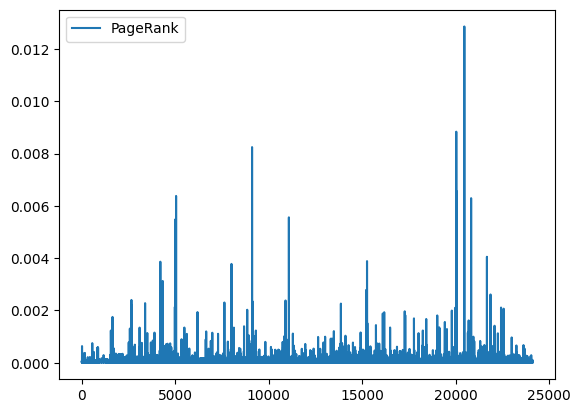

In [61]:
import matplotlib.pyplot as plt
plt.plot(range(n), v, label = "PageRank") 
plt.legend() 
plt.show()

In [67]:
import pandas as pd
pagerank = pd.Series(v).sort_values(ascending = False).head(10)
page_id = list(pagerank.index)

In [59]:
top10 = [articles[p] for p in page_id]

In [54]:
def get_english_article(link): 

    result = requests.get('https://si.wikipedia.org' + link)
    html = lx.fromstring(result.text)
    english = html.xpath('//li[@class="interlanguage-link interwiki-en mw-list-item"]/a/@href')

    try: url = english[0]
    except: url = None

    return url

def get_title(url): 

    result = requests.get(url)
    html = lx.fromstring(result.text)
    titlelist = html.xpath('//span[@class="mw-page-title-main"]')

    try: title = titlelist[0].text
    except: title = None

    return title

In [ ]:
english_urls = [get_english_article(link) for link in top10] # one is None
title = [get_title(link) for link in english_urls if link is not None]
title

#Sri Lanka
#Wayback Machine
#ISBN
#Time zone
#United Kingdom
#Sri Lanka Standard Time
#Daughter
#United States
#Coordinated Universal Time